In [1]:
# всевозможные импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [7]:
# воспроизводимость

RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [12]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)
    print('Cuda доступна ура')

Cuda доступна ура


In [14]:
df = pd.read_csv('cybersequrity.csv')

In [16]:
# форма дф
df.shape

(10000, 16)

In [18]:
df.head()
# Class - угадываемая переменная

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [20]:
# на предикторы и предикат
X = df.drop('Class', axis=1).values
y = df['Class'].values

In [26]:
print(X.shape, \
     y.shape)

(10000, 15) (10000,)


In [28]:
# Поделим в 2 этапа - 1ый 60 на 40. Второй - 40 поделим на 20 и 20

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.4, # пойдет на вал и тест
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split( # как раз делаем вал и тест
    X_temp, y_temp,
    test_size=0.5, # 50% от 40%
    stratify=y_temp,
    random_state=RANDOM_STATE
)

In [34]:
# итого размеры выборок, ничего не потерялось

print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100}%)")
print(f"Val:   {X_val.shape[0]} ({X_val.shape[0]/len(X)*100}%)")
print(f"Test:  {X_test.shape[0]} ({X_test.shape[0]/len(X)*100}%)")

Train: 6000 (60.0%)
Val:   2000 (20.0%)
Test:  2000 (20.0%)


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # показываем только тренировочные данные

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [42]:
# проверка стандартизации

print(f"Train - mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std()}")
print(f"Val   - mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std()}")
print(f"Test  - mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std()}")

Train - mean: -0.0000, std: 0.9660917830792892
Val   - mean: 0.0038, std: 1.0390897415345868
Test  - mean: 0.0083, std: 1.1092996686960532


In [48]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)

In [50]:
y_train_tensor.shape

torch.Size([6000, 1])

In [52]:
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)
y_val_tensor.shape

torch.Size([2000, 1])

In [54]:
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)
y_test_tensor.shape

torch.Size([2000, 1])

In [56]:
# делаем тензор датасеты
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [58]:
BATCH_SIZE = 32 # без понятия сколько ставить, +- рандомно

In [60]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # мешаем перед каждой эпохой данные чтобы не переобучаться и чтоб лучше было
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [64]:
# кол-во батчей
print(f"в train: {len(train_loader)}")
print(f"в val: {len(val_loader)}")
print(f"в test: {len(test_loader)}")

в train: 188
в val: 63
в test: 63


In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем {device}")

Используем cuda


In [70]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=15, hidden_sizes=[64, 32]):
        super(SimpleMLP, self).__init__()
        # 1 слой 15 входов - 64 нейрона
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        # 2 слой: 64 - 32
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        # выходной : 32 - 1, непосредственно итоговый класс
        self.fc3 = nn.Linear(hidden_sizes[1], 1)
        # ReLU для скрытых слоев, лучше тангенса, например, тем, что не затухает и хорошо работает с числами
        self.relu = nn.ReLU()
        # сигмоида для тек задачи бин классификации
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # проход данных через сеть
        # Х -> [15] -> ReLU -> [64] -> ReLU -> [32] -> Sigmoid -> [1]
        x = self.relu(self.fc1(x))  # первый слой + активация релу
        x = self.relu(self.fc2(x))  # второй слой + активация релу
        x = self.sigmoid(self.fc3(x))  # Выходной слой + Sigmoid (вероятность)
        return x


In [77]:
model = SimpleMLP(input_size=15, hidden_sizes=[64, 32]).to(device)
model

SimpleMLP(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [79]:
optimizer = optim.Adam(model.parameters(), lr=0.001) # просто пробуем, adam позволяет с лернин рейтом экспериментировать, считается круче SGD,\
# но может привести к переобучению, в дальнейшем это будет видно
loss_fn = nn.BCELoss() # бинарн кросс энтропия

In [81]:
# для ф-й потерь, объявляем даже пустые списки заранее для чистоты ноутбука
train_losses = []
val_losses = []
val_accuracies = []

In [83]:
def train_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # прямой простой проход
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch)
        # бекпропаганация
        optimizer.zero_grad()  # градиенты обнуляем
        loss.backward()        # считаем их
        optimizer.step()       # обновляем весы
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [85]:
def eval_epoch(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # не считаем градиенты чтоб память не тратить
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            total_loss += loss.item()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = np.mean((all_preds > 0.5) == all_labels)
    return total_loss / len(val_loader), accuracy

In [87]:
NUM_EPOCHS = 30 # пока тоже рандомно, скорее всего не пригодится так много эпох, тк задача учебная

In [89]:
# ОБУЧЕНИЕ
print("Начало обучения...\n")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_epoch(model, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

print("\n Обучение закончено")

Начало обучения...

Epoch  5/30 | Train Loss: 0.5413 | Val Loss: 0.5304 | Val Acc: 0.7620
Epoch 10/30 | Train Loss: 0.4963 | Val Loss: 0.5343 | Val Acc: 0.7940
Epoch 15/30 | Train Loss: 0.4633 | Val Loss: 0.4978 | Val Acc: 0.7905
Epoch 20/30 | Train Loss: 0.4541 | Val Loss: 0.4842 | Val Acc: 0.7940
Epoch 25/30 | Train Loss: 0.4371 | Val Loss: 0.4774 | Val Acc: 0.8190
Epoch 30/30 | Train Loss: 0.4286 | Val Loss: 0.4745 | Val Acc: 0.8185

 Обучение закончено


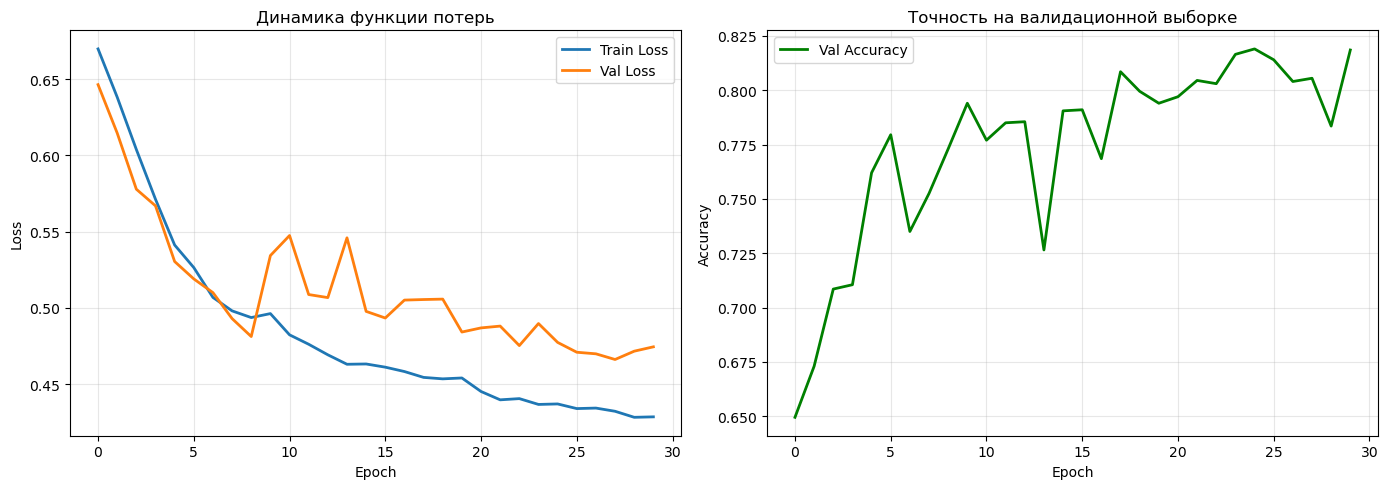

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Динамика функции потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accuracies, label='Val Accuracy', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на валидационной выборке')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_training.png', dpi=150, bbox_inches='tight')
plt.show()

In [93]:
# сначала просто попробую увеличить кол-во эпох, возможно потери упадут еще больше

In [97]:
NUM_EPOCHS_1 = 100
# ОБУЧЕНИЕ_2
print("Начало обучения...\n")
for epoch in range(NUM_EPOCHS_1):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_epoch(model, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

print("\n Обучение закончено")


Начало обучения...

Epoch  5/30 | Train Loss: 0.4069 | Val Loss: 0.4512 | Val Acc: 0.8210
Epoch 10/30 | Train Loss: 0.4002 | Val Loss: 0.4366 | Val Acc: 0.8295
Epoch 15/30 | Train Loss: 0.3967 | Val Loss: 0.4406 | Val Acc: 0.8300
Epoch 20/30 | Train Loss: 0.3929 | Val Loss: 0.4337 | Val Acc: 0.8300
Epoch 25/30 | Train Loss: 0.3878 | Val Loss: 0.4520 | Val Acc: 0.8075
Epoch 30/30 | Train Loss: 0.3837 | Val Loss: 0.4219 | Val Acc: 0.8305
Epoch 35/30 | Train Loss: 0.3884 | Val Loss: 0.4292 | Val Acc: 0.8235
Epoch 40/30 | Train Loss: 0.3799 | Val Loss: 0.4296 | Val Acc: 0.8270
Epoch 45/30 | Train Loss: 0.3750 | Val Loss: 0.4168 | Val Acc: 0.8275
Epoch 50/30 | Train Loss: 0.3774 | Val Loss: 0.4170 | Val Acc: 0.8275
Epoch 55/30 | Train Loss: 0.3700 | Val Loss: 0.4292 | Val Acc: 0.8295
Epoch 60/30 | Train Loss: 0.3664 | Val Loss: 0.4210 | Val Acc: 0.8330
Epoch 65/30 | Train Loss: 0.3680 | Val Loss: 0.4286 | Val Acc: 0.8220
Epoch 70/30 | Train Loss: 0.3722 | Val Loss: 0.4120 | Val Acc: 0.8310


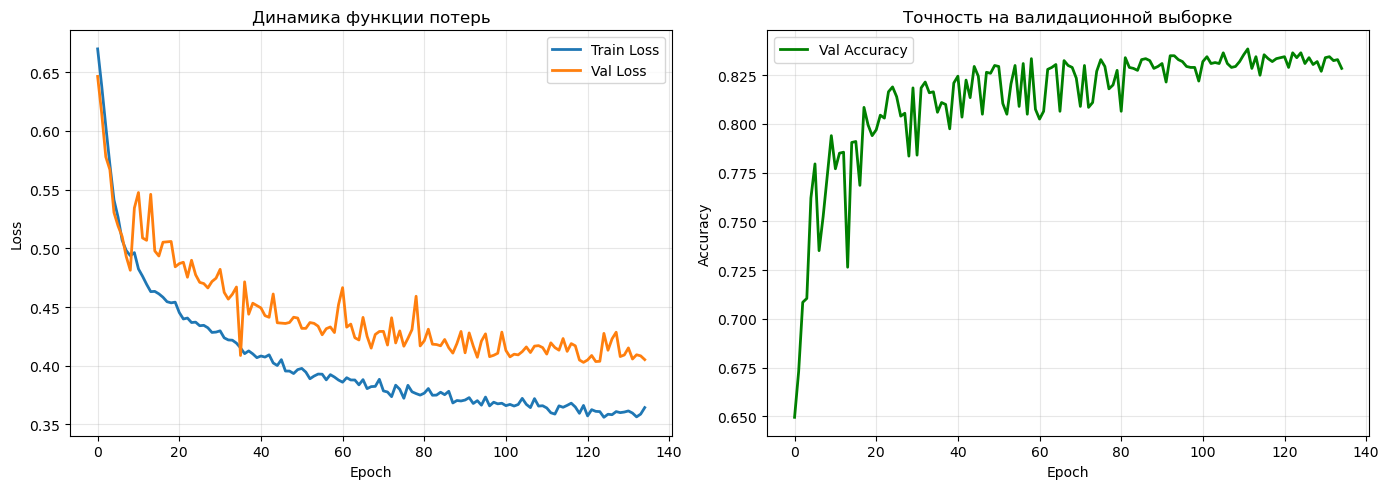

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Динамика функции потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accuracies, label='Val Accuracy', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на валидационной выборке')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_training.png', dpi=150, bbox_inches='tight')
plt.show()

Train loss постоянно падает, неплохо. Однако и на лоссах и на val accuracy есть резкие скачки и падения на +- 2-3 п.п и уменьшается с количеством эпох и в конце концов, как мне кажется, стабилизируется
тк val loss > train loss можно сказать о некотором переобучении + и стабильность у валидационных потерь меньше + увеличение кол-ва эпох не очень отразилось на точности модели
надо пробовать экспериментировать

In [103]:
test_loss, test_acc = eval_epoch(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4525
Test Accuracy: 0.8360


In [105]:
model.eval()
all_preds = []
all_labels = []

In [107]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        predictions = model(X_batch)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.numpy())
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
all_preds_binary = (all_preds > 0.5).astype(int)

In [124]:
print("CLASSIFICATION REPORT")
print(classification_report(all_labels, all_preds_binary, \
                          target_names=['Нейтральное ПО (0)', 'Вредоносное ПО (1)']))

CLASSIFICATION REPORT
                    precision    recall  f1-score   support

Нейтральное ПО (0)       0.78      0.93      0.85       981
Вредоносное ПО (1)       0.92      0.74      0.82      1019

          accuracy                           0.84      2000
         macro avg       0.85      0.84      0.84      2000
      weighted avg       0.85      0.84      0.83      2000



F1-score нормальные, Нейтральное ПО страдает пресижн, а у Вредоносное ПО  - recall. Соответственно "Нейтральное ПО" пропускаем реже, а "Вредоносное ПО" пропускаем достаточно часто, для нас скорее более приемлемо recall по определению вредоносного ПО при фиксированных значениях для нейтрального ПО

In [113]:
roc_auc = roc_auc_score(all_labels, all_preds)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9142


Интерперетация примерно такая: "с вероятностью около 91.4% модель правильно ранжирует случайно выбранный положительный пример выше случайно выбранного отрицательного"

In [121]:
cm = confusion_matrix(all_labels, all_preds_binary)
print('Conf matrix:')
print(cm)

Conf matrix:
[[913  68]
 [260 759]]


То о чем говорил выше. Моделька часто упускает вредоносное ПО (260 кейсов). В целом не так плохо, но для целевой задачи результаты модели низковаты.
Экспериментируем

In [229]:
class MLPWithBatchNorm(nn.Module):
    def __init__(self, input_size=15, hidden_sizes=[64, 32]):
        super(MLPWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [231]:
model_bn = MLPWithBatchNorm().to(device)
print("Модель с BatchNorm")
print(model_bn)

Модель с BatchNorm
MLPWithBatchNorm(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [233]:
# отдельный класс с дропаутом чтобы избавиться от переобучения с N веро-ю отключая отдельные нейроны

class MLPWithDropout(nn.Module):
    def __init__(self, input_size=15, hidden_sizes=[64, 32], dropout_p=0.2):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_sizes[1], 1) 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [235]:
model_dropout = MLPWithDropout(dropout_p=0.2).to(device) # пусть будет 0.2
print("Модель с Dropout n=0.2:")
print(model_dropout)

Модель с Dropout n=0.2:
MLPWithDropout(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [401]:
# объединяем теперь дропаут и нормализацию батчей в один класс

class MLPAdvanced(nn.Module):
    def __init__(self, input_size=15, hidden_sizes=[64, 32], dropout_p=0.2):
        super(MLPAdvanced, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.dropout1 = nn.Dropout(p=dropout_p)

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.fc3 = nn.Linear(hidden_sizes[1], 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.sigmoid(self.fc3(x))
        return x

model_advanced = MLPAdvanced(
    hidden_sizes=[64, 32],
    dropout_p=0.2
).to(device)


In [403]:
print("Итоговая модель дропаут и бетчнорм:")
print(model_advanced)

Итоговая модель дропаут и бетчнорм:
MLPAdvanced(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [405]:
# снова объявляем оптимизатор чтоб случайно не использовать старый
optimizer = optim.Adam(model_advanced.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [293]:
# потери сбрасываем
train_losses = []
val_losses = []
val_accuracies = []

In [294]:
# снова объявляем оптимизатор чтоб случайно не использовать старый
optimizer = optim.Adam(model_bn.parameters(), lr=0.001)
# loss_fn = nn.BCELoss()

# потери сбрасываем
train_losses = []
val_losses = []
val_accuracies = []

# Пробуем сначала только батч нормализацию
n = 100
print("Начало обучения...\n")
for epoch in range(n):
    train_loss = train_epoch(model_bn, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_epoch(model_bn, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1:2d}/{n} | "
    f"Train Loss: {train_loss:.4f} | "
    f"Val Loss: {val_loss:.4f} | "
    f"Val Acc: {val_acc:.4f}")

print("\nОбучение закончено")

Начало обучения...

Epoch  1/100 | Train Loss: 0.4764 | Val Loss: 0.5778 | Val Acc: 0.6855
Epoch  2/100 | Train Loss: 0.4788 | Val Loss: 0.5531 | Val Acc: 0.7400
Epoch  3/100 | Train Loss: 0.4821 | Val Loss: 0.5657 | Val Acc: 0.6685
Epoch  4/100 | Train Loss: 0.4805 | Val Loss: 0.5563 | Val Acc: 0.7585
Epoch  5/100 | Train Loss: 0.4733 | Val Loss: 0.5964 | Val Acc: 0.6190
Epoch  6/100 | Train Loss: 0.4791 | Val Loss: 0.5715 | Val Acc: 0.6890
Epoch  7/100 | Train Loss: 0.4656 | Val Loss: 0.5656 | Val Acc: 0.6810
Epoch  8/100 | Train Loss: 0.4863 | Val Loss: 0.5519 | Val Acc: 0.6610
Epoch  9/100 | Train Loss: 0.4668 | Val Loss: 0.5499 | Val Acc: 0.7095
Epoch 10/100 | Train Loss: 0.4649 | Val Loss: 0.5420 | Val Acc: 0.7770
Epoch 11/100 | Train Loss: 0.4689 | Val Loss: 0.5002 | Val Acc: 0.7055
Epoch 12/100 | Train Loss: 0.4658 | Val Loss: 0.5791 | Val Acc: 0.6690
Epoch 13/100 | Train Loss: 0.4641 | Val Loss: 0.6556 | Val Acc: 0.6125
Epoch 14/100 | Train Loss: 0.4680 | Val Loss: 0.5866 | Va

In [297]:
# снова объявляем оптимизатор чтоб случайно не использовать старый
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [299]:
# потери сбрасываем
train_losses = []
val_losses = []
val_accuracies = []

In [305]:
# снова объявляем оптимизатор чтоб случайно не использовать старый
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)
# loss_fn = nn.BCELoss()

# потери сбрасываем
train_losses = []
val_losses = []
val_accuracies = []

# Учимся только на дропауте
n = 100
print("Начало обучения...\n")
for epoch in range(n):
    train_loss = train_epoch(model_dropout, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_epoch(model_dropout, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{n} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")
print("\nОбучение закончено")

Начало обучения...

Epoch  5/100 | Train Loss: 0.3966 | Val Loss: 0.4047 | Val Acc: 0.8310
Epoch 10/100 | Train Loss: 0.3822 | Val Loss: 0.3954 | Val Acc: 0.8305
Epoch 15/100 | Train Loss: 0.3817 | Val Loss: 0.3985 | Val Acc: 0.8295
Epoch 20/100 | Train Loss: 0.3869 | Val Loss: 0.4007 | Val Acc: 0.8315
Epoch 25/100 | Train Loss: 0.3859 | Val Loss: 0.4080 | Val Acc: 0.8290
Epoch 30/100 | Train Loss: 0.3794 | Val Loss: 0.3950 | Val Acc: 0.8285
Epoch 35/100 | Train Loss: 0.3807 | Val Loss: 0.4006 | Val Acc: 0.8315
Epoch 40/100 | Train Loss: 0.3762 | Val Loss: 0.4013 | Val Acc: 0.8360
Epoch 45/100 | Train Loss: 0.3788 | Val Loss: 0.3937 | Val Acc: 0.8390
Epoch 50/100 | Train Loss: 0.3877 | Val Loss: 0.4021 | Val Acc: 0.8290
Epoch 55/100 | Train Loss: 0.3750 | Val Loss: 0.3936 | Val Acc: 0.8375
Epoch 60/100 | Train Loss: 0.3720 | Val Loss: 0.3957 | Val Acc: 0.8355
Epoch 65/100 | Train Loss: 0.3778 | Val Loss: 0.3919 | Val Acc: 0.8340
Epoch 70/100 | Train Loss: 0.3761 | Val Loss: 0.4006 | Va

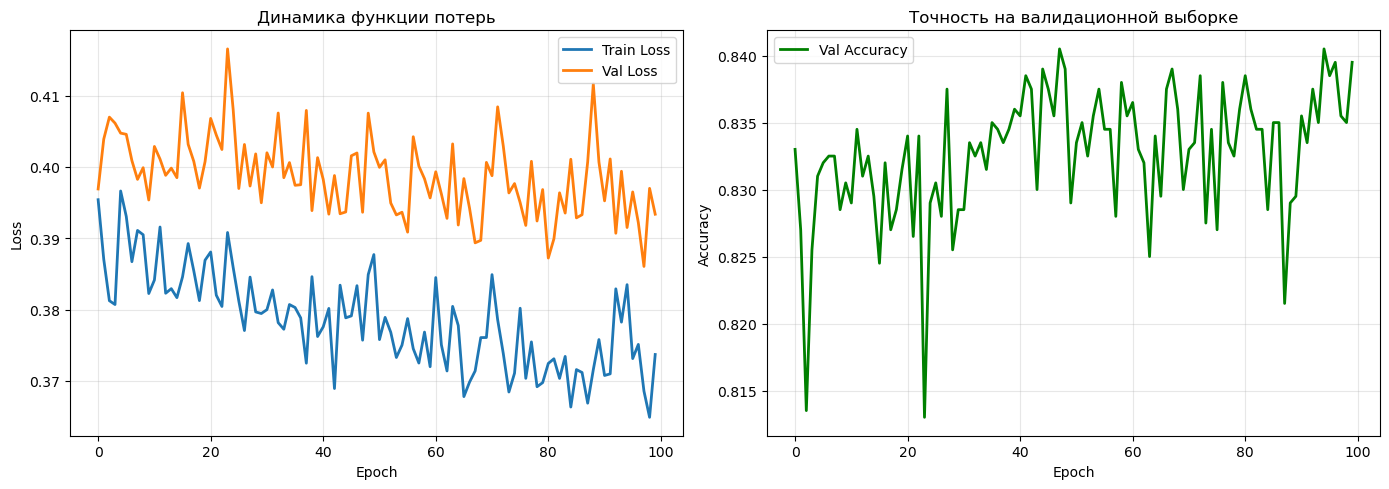

In [307]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Динамика функции потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accuracies, label='Val Accuracy', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на валидационной выборке')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_training.png', dpi=150, bbox_inches='tight')
plt.show()

In [319]:
model_dropout_04 = MLPWithDropout(dropout_p=0.4).to(device) # пусть будет теперь .4
print("Модель с Dropout n=0.4:")
print(model_dropout_04)

Модель с Dropout n=0.4:
MLPWithDropout(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [321]:
# снова объявляем оптимизатор чтоб случайно не использовать старый
optimizer = optim.Adam(model_dropout_04.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [323]:
train_losses = []
val_losses = []
val_accuracies = []

# Учимся только на дропауте
n = 500
print("Начало обучения...\n")
for epoch in range(n):
    train_loss = train_epoch(model_dropout_04, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_epoch(model_dropout_04, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d}/{n} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")
print("\nОбучение закончено")

Начало обучения...

Epoch 10/500 | Train Loss: 0.5507 | Val Loss: 0.5541 | Val Acc: 0.7795
Epoch 20/500 | Train Loss: 0.4951 | Val Loss: 0.5094 | Val Acc: 0.7895
Epoch 30/500 | Train Loss: 0.4701 | Val Loss: 0.4805 | Val Acc: 0.8150
Epoch 40/500 | Train Loss: 0.4628 | Val Loss: 0.4645 | Val Acc: 0.8025
Epoch 50/500 | Train Loss: 0.4512 | Val Loss: 0.4572 | Val Acc: 0.7975
Epoch 60/500 | Train Loss: 0.4433 | Val Loss: 0.4466 | Val Acc: 0.8190
Epoch 70/500 | Train Loss: 0.4439 | Val Loss: 0.4464 | Val Acc: 0.8045
Epoch 80/500 | Train Loss: 0.4416 | Val Loss: 0.4421 | Val Acc: 0.8185
Epoch 90/500 | Train Loss: 0.4327 | Val Loss: 0.4310 | Val Acc: 0.8225
Epoch 100/500 | Train Loss: 0.4300 | Val Loss: 0.4303 | Val Acc: 0.8295
Epoch 110/500 | Train Loss: 0.4293 | Val Loss: 0.4441 | Val Acc: 0.8235
Epoch 120/500 | Train Loss: 0.4288 | Val Loss: 0.4401 | Val Acc: 0.8155
Epoch 130/500 | Train Loss: 0.4239 | Val Loss: 0.4237 | Val Acc: 0.8225
Epoch 140/500 | Train Loss: 0.4175 | Val Loss: 0.4327

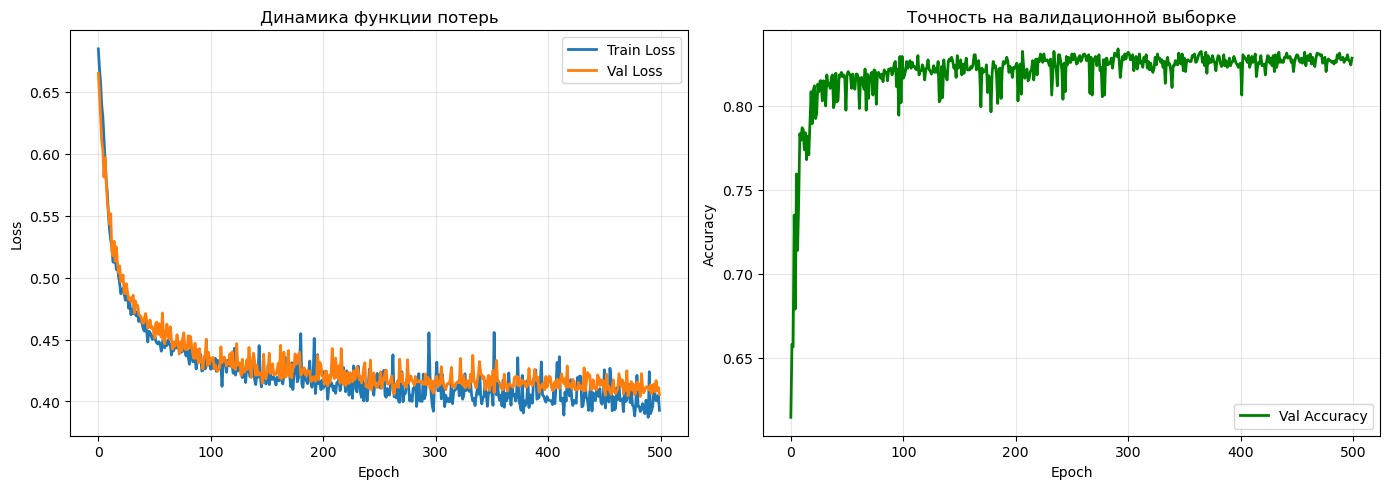

In [325]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Динамика функции потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accuracies, label='Val Accuracy', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на валидационной выборке')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_training.png', dpi=150, bbox_inches='tight')
plt.show()

In [393]:
class LeakyReLu_MLP_dropOut(nn.Module):
    def __init__(self, input_size=15, hidden_sizes=[64, 32], dropout_prob=0.3):
        super(LeakyReLu_MLP_dropOut, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], 1)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x) # применяем дропаут после активации первого слоя
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x) # дропаут после второго слоя
        x = self.sigmoid(self.fc3(x))
        return x

In [395]:
leakyReLu_model_dropout_03 = LeakyReLu_MLP_dropOut(input_size=15, hidden_sizes=[64, 32], dropout_prob=0.3).to(device)
print("Модель с Dropout n=0.3:")
print(leakyReLu_model_dropout_03)

optimizer = optim.Adam(leakyReLu_model_dropout_03.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

Модель с Dropout n=0.3:
LeakyReLu_MLP_dropOut(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


In [397]:
train_losses = []
val_losses = []
val_accuracies = []

# Учимся только на дропауте
n = 150
print("Начало обучения...\n")
for epoch in range(n):
    train_loss = train_epoch(leakyReLu_model_dropout_03, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_epoch(leakyReLu_model_dropout_03, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d}/{n} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")
print("\nОбучение закончено")

Начало обучения...

Epoch 10/150 | Train Loss: 0.5336 | Val Loss: 0.5609 | Val Acc: 0.7425
Epoch 20/150 | Train Loss: 0.4868 | Val Loss: 0.4975 | Val Acc: 0.7895
Epoch 30/150 | Train Loss: 0.4581 | Val Loss: 0.4764 | Val Acc: 0.8060
Epoch 40/150 | Train Loss: 0.4445 | Val Loss: 0.4575 | Val Acc: 0.8185
Epoch 50/150 | Train Loss: 0.4307 | Val Loss: 0.4421 | Val Acc: 0.8260
Epoch 60/150 | Train Loss: 0.4231 | Val Loss: 0.4473 | Val Acc: 0.8120
Epoch 70/150 | Train Loss: 0.4224 | Val Loss: 0.4365 | Val Acc: 0.8210
Epoch 80/150 | Train Loss: 0.4160 | Val Loss: 0.4312 | Val Acc: 0.8270
Epoch 90/150 | Train Loss: 0.4177 | Val Loss: 0.4238 | Val Acc: 0.8245
Epoch 100/150 | Train Loss: 0.4093 | Val Loss: 0.4208 | Val Acc: 0.8285
Epoch 110/150 | Train Loss: 0.4173 | Val Loss: 0.4186 | Val Acc: 0.8285
Epoch 120/150 | Train Loss: 0.4047 | Val Loss: 0.4376 | Val Acc: 0.8260
Epoch 130/150 | Train Loss: 0.4031 | Val Loss: 0.4219 | Val Acc: 0.8160
Epoch 140/150 | Train Loss: 0.3952 | Val Loss: 0.4102

In [ ]:
# Достигнутый максимум до сих пор это простое применение дропаута со значением 0.2 с ReLu функций активации внутренних слоев
# на финал попробуем совместить батч нормализацию с дропаутом 0.2

In [407]:
optimizer = optim.Adam(model_advanced.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_losses = []
val_losses = []
val_accuracies = []

# Учимся только на дропауте
n = 150
print("Начало обучения...\n")
for epoch in range(n):
    train_loss = train_epoch(model_advanced, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_epoch(model_advanced, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d}/{n} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")
print("\nОбучение закончено")

Начало обучения...

Epoch 10/150 | Train Loss: 0.5204 | Val Loss: 0.5851 | Val Acc: 0.6395
Epoch 20/150 | Train Loss: 0.5060 | Val Loss: 0.5501 | Val Acc: 0.6755
Epoch 30/150 | Train Loss: 0.5045 | Val Loss: 0.5444 | Val Acc: 0.6900
Epoch 40/150 | Train Loss: 0.4904 | Val Loss: 0.5334 | Val Acc: 0.6915
Epoch 50/150 | Train Loss: 0.4822 | Val Loss: 0.4976 | Val Acc: 0.7330
Epoch 60/150 | Train Loss: 0.4830 | Val Loss: 0.4659 | Val Acc: 0.7700
Epoch 70/150 | Train Loss: 0.4815 | Val Loss: 0.6611 | Val Acc: 0.5920
Epoch 80/150 | Train Loss: 0.4690 | Val Loss: 0.5072 | Val Acc: 0.7955
Epoch 90/150 | Train Loss: 0.4745 | Val Loss: 0.4776 | Val Acc: 0.7875
Epoch 100/150 | Train Loss: 0.4667 | Val Loss: 0.5774 | Val Acc: 0.6480
Epoch 110/150 | Train Loss: 0.4636 | Val Loss: 0.5367 | Val Acc: 0.7035
Epoch 120/150 | Train Loss: 0.4630 | Val Loss: 0.4939 | Val Acc: 0.7800
Epoch 130/150 | Train Loss: 0.4639 | Val Loss: 0.4954 | Val Acc: 0.7760
Epoch 140/150 | Train Loss: 0.4660 | Val Loss: 0.6087

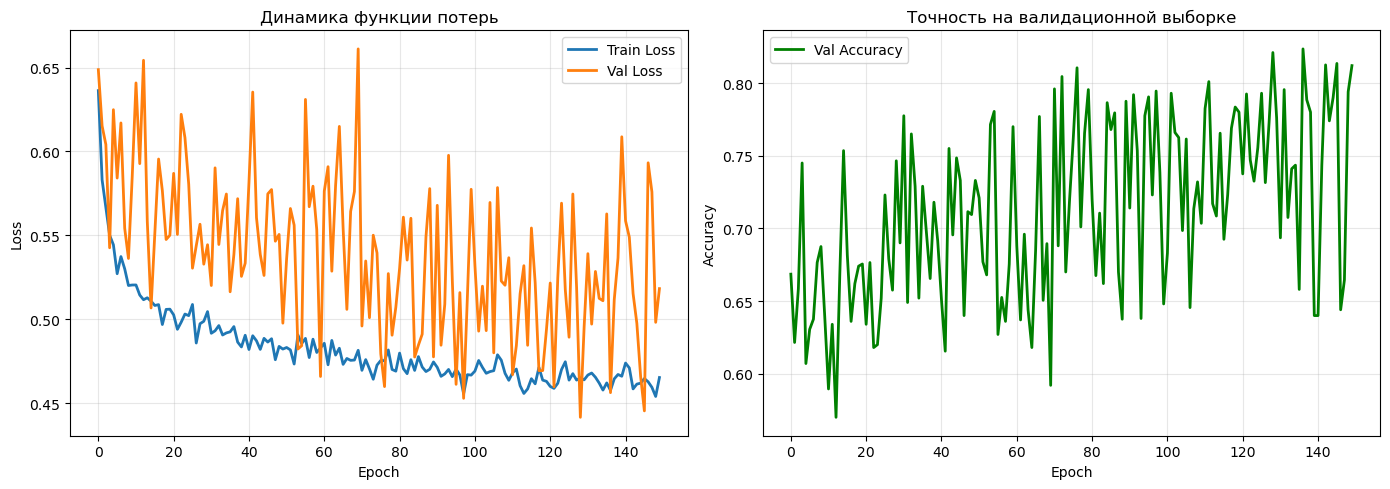

In [409]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Динамика функции потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accuracies, label='Val Accuracy', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на валидационной выборке')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_training.png', dpi=150, bbox_inches='tight')
plt.show()